In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from scipy.stats import chi2_contingency, pointbiserialr
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
# 1. CHARGEMENT DES DONNÉES
df = pd.read_csv('C:/Users/tneron2023/PycharmProjects/Python_IA/project_hotel/datas/Hotel_clean.csv')

In [6]:
# Variable cible
target = 'booking_status_Not_Canceled'
y = df[target]
X = df.drop(target, axis=1)

print(f"Dataset shape: {df.shape}")
print(f"Taux d'annulation: {(1-y.mean())*100:.1f}%")

Dataset shape: (29999, 31)
Taux d'annulation: 32.7%


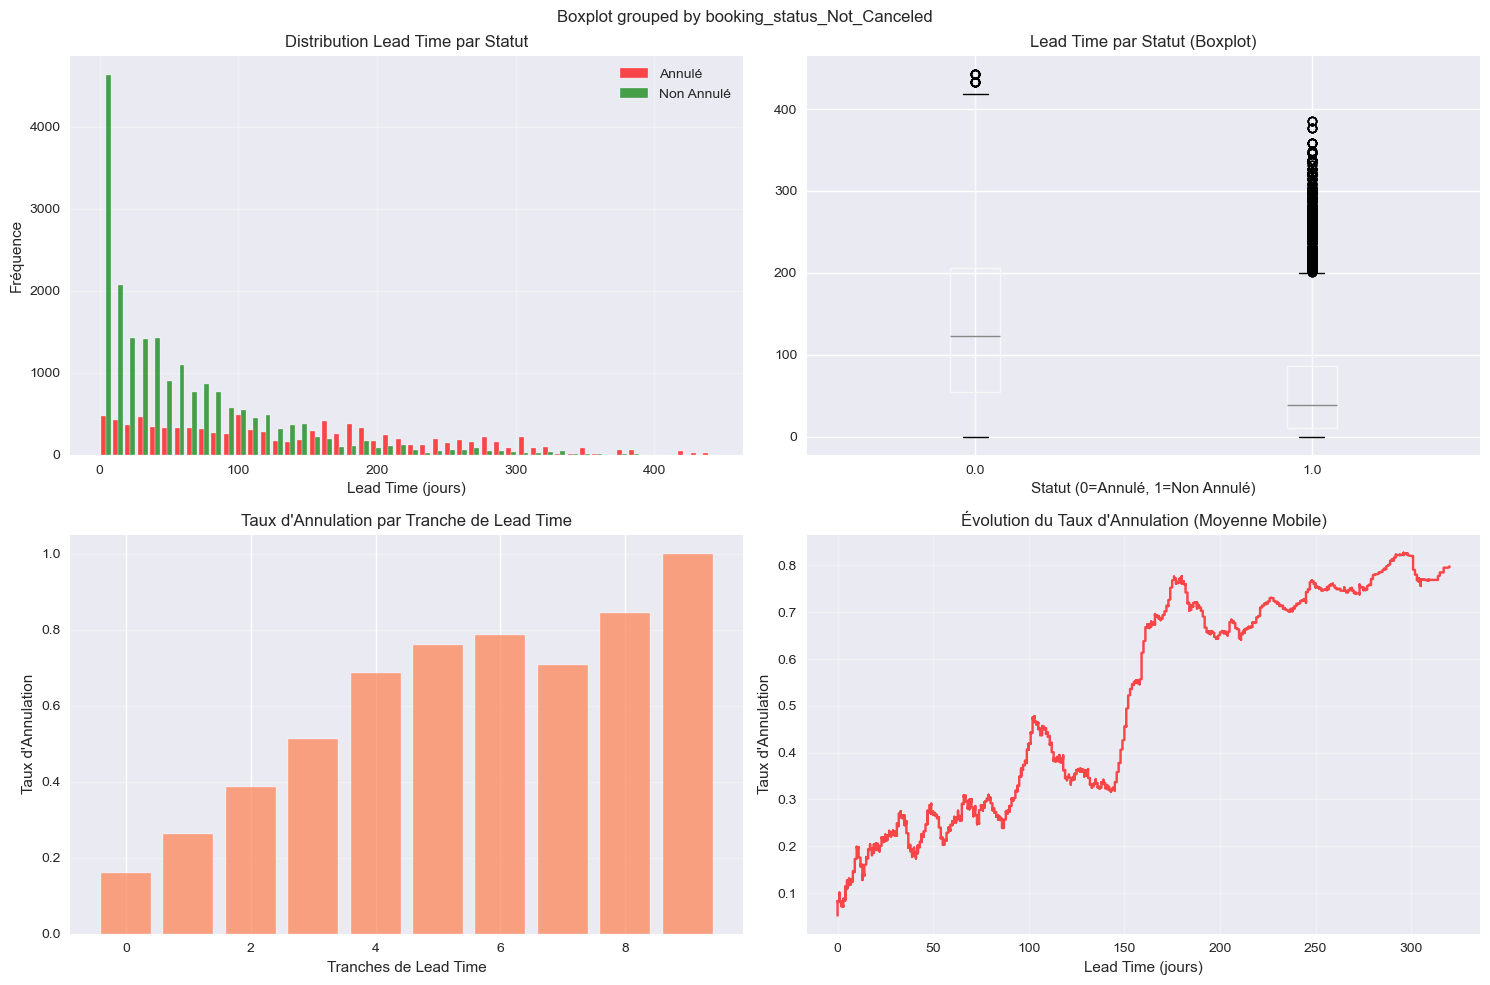

In [7]:
# 2. ANALYSE SPÉCIFIQUE DU LEAD_TIME
# Distribution du lead_time par statut
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Analyse du Lead Time vs Annulation', fontsize=16)

# Histogramme par statut
canceled = df[df[target] == 0]['lead_time']
not_canceled = df[df[target] == 1]['lead_time']

axes[0, 0].hist([canceled, not_canceled], bins=50, alpha=0.7,
                label=['Annulé', 'Non Annulé'], color=['red', 'green'])
axes[0, 0].set_title('Distribution Lead Time par Statut')
axes[0, 0].set_xlabel('Lead Time (jours)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Boxplot
df.boxplot(column='lead_time', by=target, ax=axes[0, 1])
axes[0, 1].set_title('Lead Time par Statut (Boxplot)')
axes[0, 1].set_xlabel('Statut (0=Annulé, 1=Non Annulé)')

# Taux d'annulation par tranche de lead_time
lead_time_bins = pd.cut(df['lead_time'], bins=10)
cancellation_rate = df.groupby(lead_time_bins)[target].agg(['mean', 'count'])
cancellation_rate['cancellation_rate'] = 1 - cancellation_rate['mean']

axes[1, 0].bar(range(len(cancellation_rate)), cancellation_rate['cancellation_rate'],
               color='coral', alpha=0.7)
axes[1, 0].set_title('Taux d\'Annulation par Tranche de Lead Time')
axes[1, 0].set_xlabel('Tranches de Lead Time')
axes[1, 0].set_ylabel('Taux d\'Annulation')
axes[1, 0].grid(axis='y', alpha=0.3)

# Moyenne mobile du taux d'annulation
df_sorted = df.sort_values('lead_time')
df_sorted['rolling_cancellation'] = (1 - df_sorted[target]).rolling(window=1000, center=True).mean()
axes[1, 1].plot(df_sorted['lead_time'], df_sorted['rolling_cancellation'], color='red', alpha=0.7)
axes[1, 1].set_title('Évolution du Taux d\'Annulation (Moyenne Mobile)')
axes[1, 1].set_xlabel('Lead Time (jours)')
axes[1, 1].set_ylabel('Taux d\'Annulation')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Statistiques descriptives du lead_time
print("\n📊 STATISTIQUES LEAD_TIME PAR STATUT:")
lead_stats = df.groupby(target)['lead_time'].describe()
print(lead_stats)


📊 STATISTIQUES LEAD_TIME PAR STATUT:
                               count        mean        std  min   25%    50%  \
booking_status_Not_Canceled                                                     
0.0                           9815.0  139.884157  99.073545  0.0  55.0  123.0   
1.0                          20184.0   59.059057  64.038449  0.0  10.0   39.0   

                               75%    max  
booking_status_Not_Canceled                
0.0                          206.0  443.0  
1.0                           86.0  386.0  


In [9]:
# Test statistique de différence
from scipy.stats import mannwhitneyu
statistic, p_value = mannwhitneyu(canceled, not_canceled, alternative='two-sided')
print(f"\n🧪 Test Mann-Whitney U:")
print(f"   Statistique: {statistic}")
print(f"   P-value: {p_value:.2e}")
print(f"   Significatif: {'OUI' if p_value < 0.05 else 'NON'}")


🧪 Test Mann-Whitney U:
   Statistique: 150194863.5
   P-value: 0.00e+00
   Significatif: OUI


In [10]:
# Corrélation point-bisériale (lead_time vs annulation)
correlation, p_val = pointbiserialr(y, df['lead_time'])
print(f"\n📈 Corrélation Lead_Time vs Annulation:")
print(f"   Corrélation: {correlation:.3f}")
print(f"   P-value: {p_val:.2e}")


📈 Corrélation Lead_Time vs Annulation:
   Corrélation: -0.441
   P-value: 0.00e+00


In [11]:
# 3. FEATURE ENGINEERING - NOUVELLES VARIABLES
# Copie pour éviter de modifier l'original
df_enhanced = df.copy()

# Nouvelles variables basées sur lead_time
df_enhanced['lead_time_category'] = pd.cut(df['lead_time'],
                                         bins=[0, 7, 30, 90, 365, 999],
                                         labels=['Très_Court', 'Court', 'Moyen', 'Long', 'Très_Long'])

# Variables dérivées temporelles
df_enhanced['total_nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']
df_enhanced['weekend_ratio'] = df['no_of_weekend_nights'] / (df_enhanced['total_nights'] + 1e-8)
df_enhanced['total_guests'] = df['no_of_adults'] + df['no_of_children']
df_enhanced['price_per_guest'] = df['avg_price_per_room'] / (df_enhanced['total_guests'] + 1e-8)
df_enhanced['price_per_night'] = df['avg_price_per_room'] / (df_enhanced['total_nights'] + 1e-8)

# Variables d'expérience client
df_enhanced['customer_experience'] = (df['no_of_previous_bookings_not_canceled'] -
                                    df['no_of_previous_cancellations'])
df_enhanced['loyalty_score'] = df['repeated_guest'] * df_enhanced['customer_experience']

# Variables de risque
df_enhanced['high_lead_time'] = (df['lead_time'] > 90).astype(int)
df_enhanced['expensive_booking'] = (df['avg_price_per_room'] > df['avg_price_per_room'].quantile(0.75)).astype(int)
df_enhanced['complex_booking'] = (df['no_of_special_requests'] > 2).astype(int)

# Variables saisonnières
df_enhanced['peak_season'] = df['arrival_month'].isin([6, 7, 8, 12]).astype(int)
df_enhanced['weekend_arrival'] = df['arrival_date'].apply(lambda x: 1 if x % 7 in [0, 6] else 0)

print(f"✅ Nouvelles variables créées: {len(df_enhanced.columns) - len(df.columns)}")
print(f"Variables ajoutées: {[col for col in df_enhanced.columns if col not in df.columns]}")


✅ Nouvelles variables créées: 13
Variables ajoutées: ['lead_time_category', 'total_nights', 'weekend_ratio', 'total_guests', 'price_per_guest', 'price_per_night', 'customer_experience', 'loyalty_score', 'high_lead_time', 'expensive_booking', 'complex_booking', 'peak_season', 'weekend_arrival']


In [12]:
# 4. ANALYSE D'IMPORTANCE MULTI-MÉTHODES
# Préparation des données
X_enhanced = df_enhanced.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# 4.1 Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("🏆 TOP 15 FEATURES (Random Forest):")
print(rf_importance.head(15))

ValueError: could not convert string to float: 'Court'

In [14]:
# 4.2 Permutation Importance
print("\n🔄 4.2 PERMUTATION IMPORTANCE")
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

perm_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("🏆 TOP 15 FEATURES (Permutation):")
print(perm_df.head(15))


🔄 4.2 PERMUTATION IMPORTANCE


AttributeError: 'RandomForestClassifier' object has no attribute 'estimators_'

In [15]:
# 4.3 Mutual Information
print("\n🧠 4.3 MUTUAL INFORMATION")
# Encodage des variables catégorielles pour mutual info
X_train_encoded = X_train.copy()
categorical_cols = X_train_encoded.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X_train_encoded[col] = pd.Categorical(X_train_encoded[col]).codes

mi_scores = mutual_info_classif(X_train_encoded, y_train, random_state=42)
mi_df = pd.DataFrame({
    'feature': X_train.columns,
    'mutual_info': mi_scores
}).sort_values('mutual_info', ascending=False)

print("🏆 TOP 15 FEATURES (Mutual Information):")
print(mi_df.head(15))


🧠 4.3 MUTUAL INFORMATION


ValueError: Input contains NaN

In [16]:
# 4.4 Corrélation avec la target
print("\n📊 4.4 CORRÉLATION AVEC LA TARGET")
correlations = []
for col in X_train.select_dtypes(include=[np.number]).columns:
    corr, p_val = pointbiserialr(y_train, X_train[col])
    correlations.append({
        'feature': col,
        'correlation': abs(corr),
        'p_value': p_val
    })

corr_df = pd.DataFrame(correlations).sort_values('correlation', ascending=False)
print("🏆 TOP 15 FEATURES (Corrélation):")
print(corr_df.head(15))


📊 4.4 CORRÉLATION AVEC LA TARGET
🏆 TOP 15 FEATURES (Corrélation):
                          feature  correlation        p_value
5                       lead_time     0.441992   0.000000e+00
37                 high_lead_time     0.385190   0.000000e+00
13         no_of_special_requests     0.252358   0.000000e+00
6                    arrival_year     0.175966  3.671940e-166
12             avg_price_per_room     0.136299  7.266388e-100
29     market_segment_type_Online     0.118721   4.651885e-76
27  market_segment_type_Corporate     0.114739   3.920941e-71
9                  repeated_guest     0.105281   4.047337e-60
39                complex_booking     0.103574   3.110401e-58
30                   total_nights     0.096331   1.396091e-50
4      required_car_parking_space     0.090100   1.907567e-44
15  type_of_meal_plan_Meal Plan 2     0.087447   5.851862e-42
3               no_of_week_nights     0.086162   8.808308e-41
32                   total_guests     0.084553   2.483615e-39
0  

In [ ]:
# 5. VISUALISATIONS COMPARATIVES
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Comparaison des Méthodes d\'Importance des Features', fontsize=16)

# Random Forest
top_rf = rf_importance.head(15)
axes[0, 0].barh(range(len(top_rf)), top_rf['importance'], color='forestgreen')
axes[0, 0].set_yticks(range(len(top_rf)))
axes[0, 0].set_yticklabels(top_rf['feature'])
axes[0, 0].set_title('Random Forest Feature Importance')
axes[0, 0].invert_yaxis()

# Permutation
top_perm = perm_df.head(15)
axes[0, 1].barh(range(len(top_perm)), top_perm['importance_mean'],
                xerr=top_perm['importance_std'], color='coral')
axes[0, 1].set_yticks(range(len(top_perm)))
axes[0, 1].set_yticklabels(top_perm['feature'])
axes[0, 1].set_title('Permutation Importance')
axes[0, 1].invert_yaxis()

# Mutual Information
top_mi = mi_df.head(15)
axes[1, 0].barh(range(len(top_mi)), top_mi['mutual_info'], color='skyblue')
axes[1, 0].set_yticks(range(len(top_mi)))
axes[1, 0].set_yticklabels(top_mi['feature'])
axes[1, 0].set_title('Mutual Information')
axes[1, 0].invert_yaxis()

# Corrélation
top_corr = corr_df.head(15)
axes[1, 1].barh(range(len(top_corr)), top_corr['correlation'], color='gold')
axes[1, 1].set_yticks(range(len(top_corr)))
axes[1, 1].set_yticklabels(top_corr['feature'])
axes[1, 1].set_title('Corrélation Absolue')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# 6. SYNTHÈSE ET RANKING GLOBAL
print("\n🏅 6. SYNTHÈSE ET RANKING GLOBAL")

# Normalisation des scores pour comparaison
def normalize_scores(scores):
    return (scores - scores.min()) / (scores.max() - scores.min())

# Création du ranking global
all_features = set(X_train.columns)
feature_scores = {}

for feature in all_features:
    scores = []

    # Score Random Forest
    rf_score = rf_importance[rf_importance['feature'] == feature]['importance'].iloc[0] if feature in rf_importance['feature'].values else 0
    scores.append(rf_score)

    # Score Permutation
    perm_score = perm_df[perm_df['feature'] == feature]['importance_mean'].iloc[0] if feature in perm_df['feature'].values else 0
    scores.append(perm_score)

    # Score Mutual Info
    mi_score = mi_df[mi_df['feature'] == feature]['mutual_info'].iloc[0] if feature in mi_df['feature'].values else 0
    scores.append(mi_score)

    # Score Corrélation (si numérique)
    if feature in corr_df['feature'].values:
        corr_score = corr_df[corr_df['feature'] == feature]['correlation'].iloc[0]
        scores.append(corr_score)

    feature_scores[feature] = np.mean(scores)

# Ranking final
final_ranking = pd.DataFrame({
    'feature': list(feature_scores.keys()),
    'average_score': list(feature_scores.values())
}).sort_values('average_score', ascending=False)

print("🏆 RANKING FINAL DES FEATURES (Moyenne des méthodes):")
print(final_ranking.head(20))

# Position du lead_time
lead_time_position = final_ranking[final_ranking['feature'] == 'lead_time'].index[0] + 1
lead_time_score = final_ranking[final_ranking['feature'] == 'lead_time']['average_score'].iloc[0]

print(f"\n⏰ LEAD_TIME:")
print(f"   Position dans le ranking: #{lead_time_position}")
print(f"   Score moyen: {lead_time_score:.4f}")
print(f"   Top 5?: {'OUI' if lead_time_position <= 5 else 'NON'}")
print(f"   Top 10?: {'OUI' if lead_time_position <= 10 else 'NON'}")

In [ ]:
# 7. ANALYSE DE L'EFFET COMBINÉ
print("\n🔗 7. ANALYSE DES EFFETS COMBINÉS")

# Matrice de corrélation des top features
top_features = final_ranking.head(10)['feature'].tolist()
numeric_features = [f for f in top_features if f in X_train.select_dtypes(include=[np.number]).columns]

if len(numeric_features) > 1:
    plt.figure(figsize=(12, 10))
    corr_matrix = X_train[numeric_features].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Corrélations entre Top Features Numériques')
    plt.show()

In [ ]:
# 8. RECOMMANDATIONS
print("\n💡 8. RECOMMANDATIONS STRATÉGIQUES")

print("\n🎯 STRATÉGIES BASÉES SUR LEAD_TIME:")
if lead_time_position <= 5:
    print("   ✅ Lead_time est EFFECTIVEMENT un critère déterminant (Top 5)")
    print("   📈 Recommandations:")
    print("      • Politique tarifaire basée sur le lead_time")
    print("      • Communication proactive pour réservations >90j")
    print("      • Conditions d'annulation ajustées selon lead_time")
else:
    print("   ⚠️ Lead_time n'est pas dans le Top 5, mais reste important")
    print("   📈 Recommandations:")
    print("      • Combiner lead_time avec d'autres variables")
    print("      • Créer des segments de risque multi-critères")

print(f"\n🏆 VARIABLES LES PLUS PRÉDICTIVES:")
for i, row in final_ranking.head(10).iterrows():
    print(f"   {i+1}. {row['feature']} (score: {row['average_score']:.4f})")

print(f"\n🔧 NOUVELLES VARIABLES PERFORMANTES:")
new_vars = [col for col in df_enhanced.columns if col not in df.columns and col != target]
new_var_scores = final_ranking[final_ranking['feature'].isin(new_vars)]
if not new_var_scores.empty:
    for _, row in new_var_scores.head(5).iterrows():
        print(f"   • {row['feature']} (score: {row['average_score']:.4f})")

In [ ]:
# Sauvegarde du dataset enrichi
output_path = 'C:/Users/tneron2023/PycharmProjects/Python_IA/project_hotel/datas/Hotel_enhanced.csv'
df_enhanced.to_csv(output_path, index=False)
print(f"\n💾 Dataset enrichi sauvegardé: {output_path}")

print("\n🎉 ANALYSE TERMINÉE!")
print(f"📊 Lead_time validé comme critère {'MAJEUR' if lead_time_position <= 5 else 'IMPORTANT'}")
print(f"🚀 {len(new_vars)} nouvelles variables créées pour améliorer les prédictions")